# Hymba 아키텍처 시각화 및 검증

## 목표
1. 공식 Hymba-1.5B 구성 시각화
2. Global/Local Attention 패턴 검증
3. 어텐션 맵 시각화 (Global vs Local 분리)
4. KV-Cache 공유 메커니즘 확인

## 공식 Hymba-1.5B 구성
- 총 32 레이어
- **Global Attention**: 레이어 0, 15, 31 (첫/중간/마지막)
- **Local Attention (SWA)**: 나머지 레이어 (1-14, 16-30)
- **Sliding Window**: 1024 토큰
- **Meta Tokens**: 128개

In [1]:
import sys
import os
sys.path.append('./backbone')

import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Rectangle
import seaborn as sns
import numpy as np
import pandas as pd

from hymba import Hymba, HymbaConfig, ArchType, AttentionType

# 결과 저장 폴더
RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# 시각화 설정
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 150
sns.set_style("whitegrid")

# 디바이스
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"디바이스: {device}")
print(f"결과 저장 폴더: {RESULTS_DIR}")

디바이스: cuda
결과 저장 폴더: ./results


## 1. 공식 Hymba-1.5B 구성

In [2]:
# Hymba-1.5B 스케일 모델 (시각화용으로 조정)
config = HymbaConfig(
    vocab_size=8000,
    d_model=512,  # 시각화용으로 축소
    n_layers=12,  # 시각화용으로 축소
    n_heads=8,
    n_kv_heads=4,
    arch_type=ArchType.HYBRID,
    
    # Mamba:Transformer 비율 (1:1)
    mamba_heads_per_layer=1,
    
    # Global/Local 패턴 (첫/중간/마지막)
    global_attn_indices=[0, 5, 11],
    swa_window=256,  # 시각화용으로 축소
    
    # Meta Tokens (시각화를 위해 줄임)
    use_meta_tokens=True,
    num_meta_tokens=32,  # 128 -> 32로 축소 (시각화 가독성)
    
    # KV 공유
    use_kv_sharing=True,
)

model = Hymba(config)

print("=== Hymba 시각화용 모델 ===")
params = model.count_parameters()
print(f"파라미터: {params['total']:,}")
print(f"모델 크기: {params['total'] * 4 / 1024**3:.2f} GB (FP32)")

# 아키텍처 정보
arch_info = model.get_architecture_info()
print(f"\n아키텍처: {arch_info['arch_type']}")
print(f"총 Attention heads: {arch_info['total_attn_heads']}")
print(f"총 Mamba heads: {arch_info['total_mamba_heads']}")
print(f"\nMeta Tokens: {config.num_meta_tokens}")
print(f"SWA Window: {config.swa_window}")

=== Hymba 시각화용 모델 ===
파라미터: 71,672,320
모델 크기: 0.27 GB (FP32)

아키텍처: hybrid
총 Attention heads: 96
총 Mamba heads: 12

Meta Tokens: 32
SWA Window: 256


## 2. Attention 패턴 시각화

In [3]:
# 어텐션 패턴 정보
attn_info = model.get_attention_pattern_info()

print("=== Attention 패턴 ===")
print(f"전체 레이어: {attn_info['total_layers']}")
print(f"\nGlobal Attention 레이어: {attn_info['global_layers']}")
print(f"개수: {attn_info['num_global']}")
print(f"\nLocal Attention 레이어: {attn_info['local_layers']}")
print(f"개수: {attn_info['num_local']}")

# DataFrame으로 정리
layer_data = []
attn_types = config.get_attention_types()
for i in range(config.n_layers):
    layer_data.append({
        "Layer": i,
        "Attention": "Global" if attn_types[i] == AttentionType.GLOBAL else "Local (SWA)",
        "Window": "Full" if attn_types[i] == AttentionType.GLOBAL else config.swa_window,
        "KV Owner": model.owner[i],
    })

df = pd.DataFrame(layer_data)
print("\n=== 레이어별 구성 ===")
print(df.to_string(index=False))

=== Attention 패턴 ===
전체 레이어: 12

Global Attention 레이어: [0, 5, 11]
개수: 3

Local Attention 레이어: [1, 2, 3, 4, 6, 7, 8, 9, 10]
개수: 9

=== 레이어별 구성 ===
 Layer   Attention Window  KV Owner
     0      Global   Full         0
     1 Local (SWA)    256         1
     2 Local (SWA)    256         1
     3 Local (SWA)    256         3
     4 Local (SWA)    256         3
     5      Global   Full         5
     6 Local (SWA)    256         6
     7 Local (SWA)    256         6
     8 Local (SWA)    256         8
     9 Local (SWA)    256         8
    10 Local (SWA)    256        10
    11      Global   Full        11


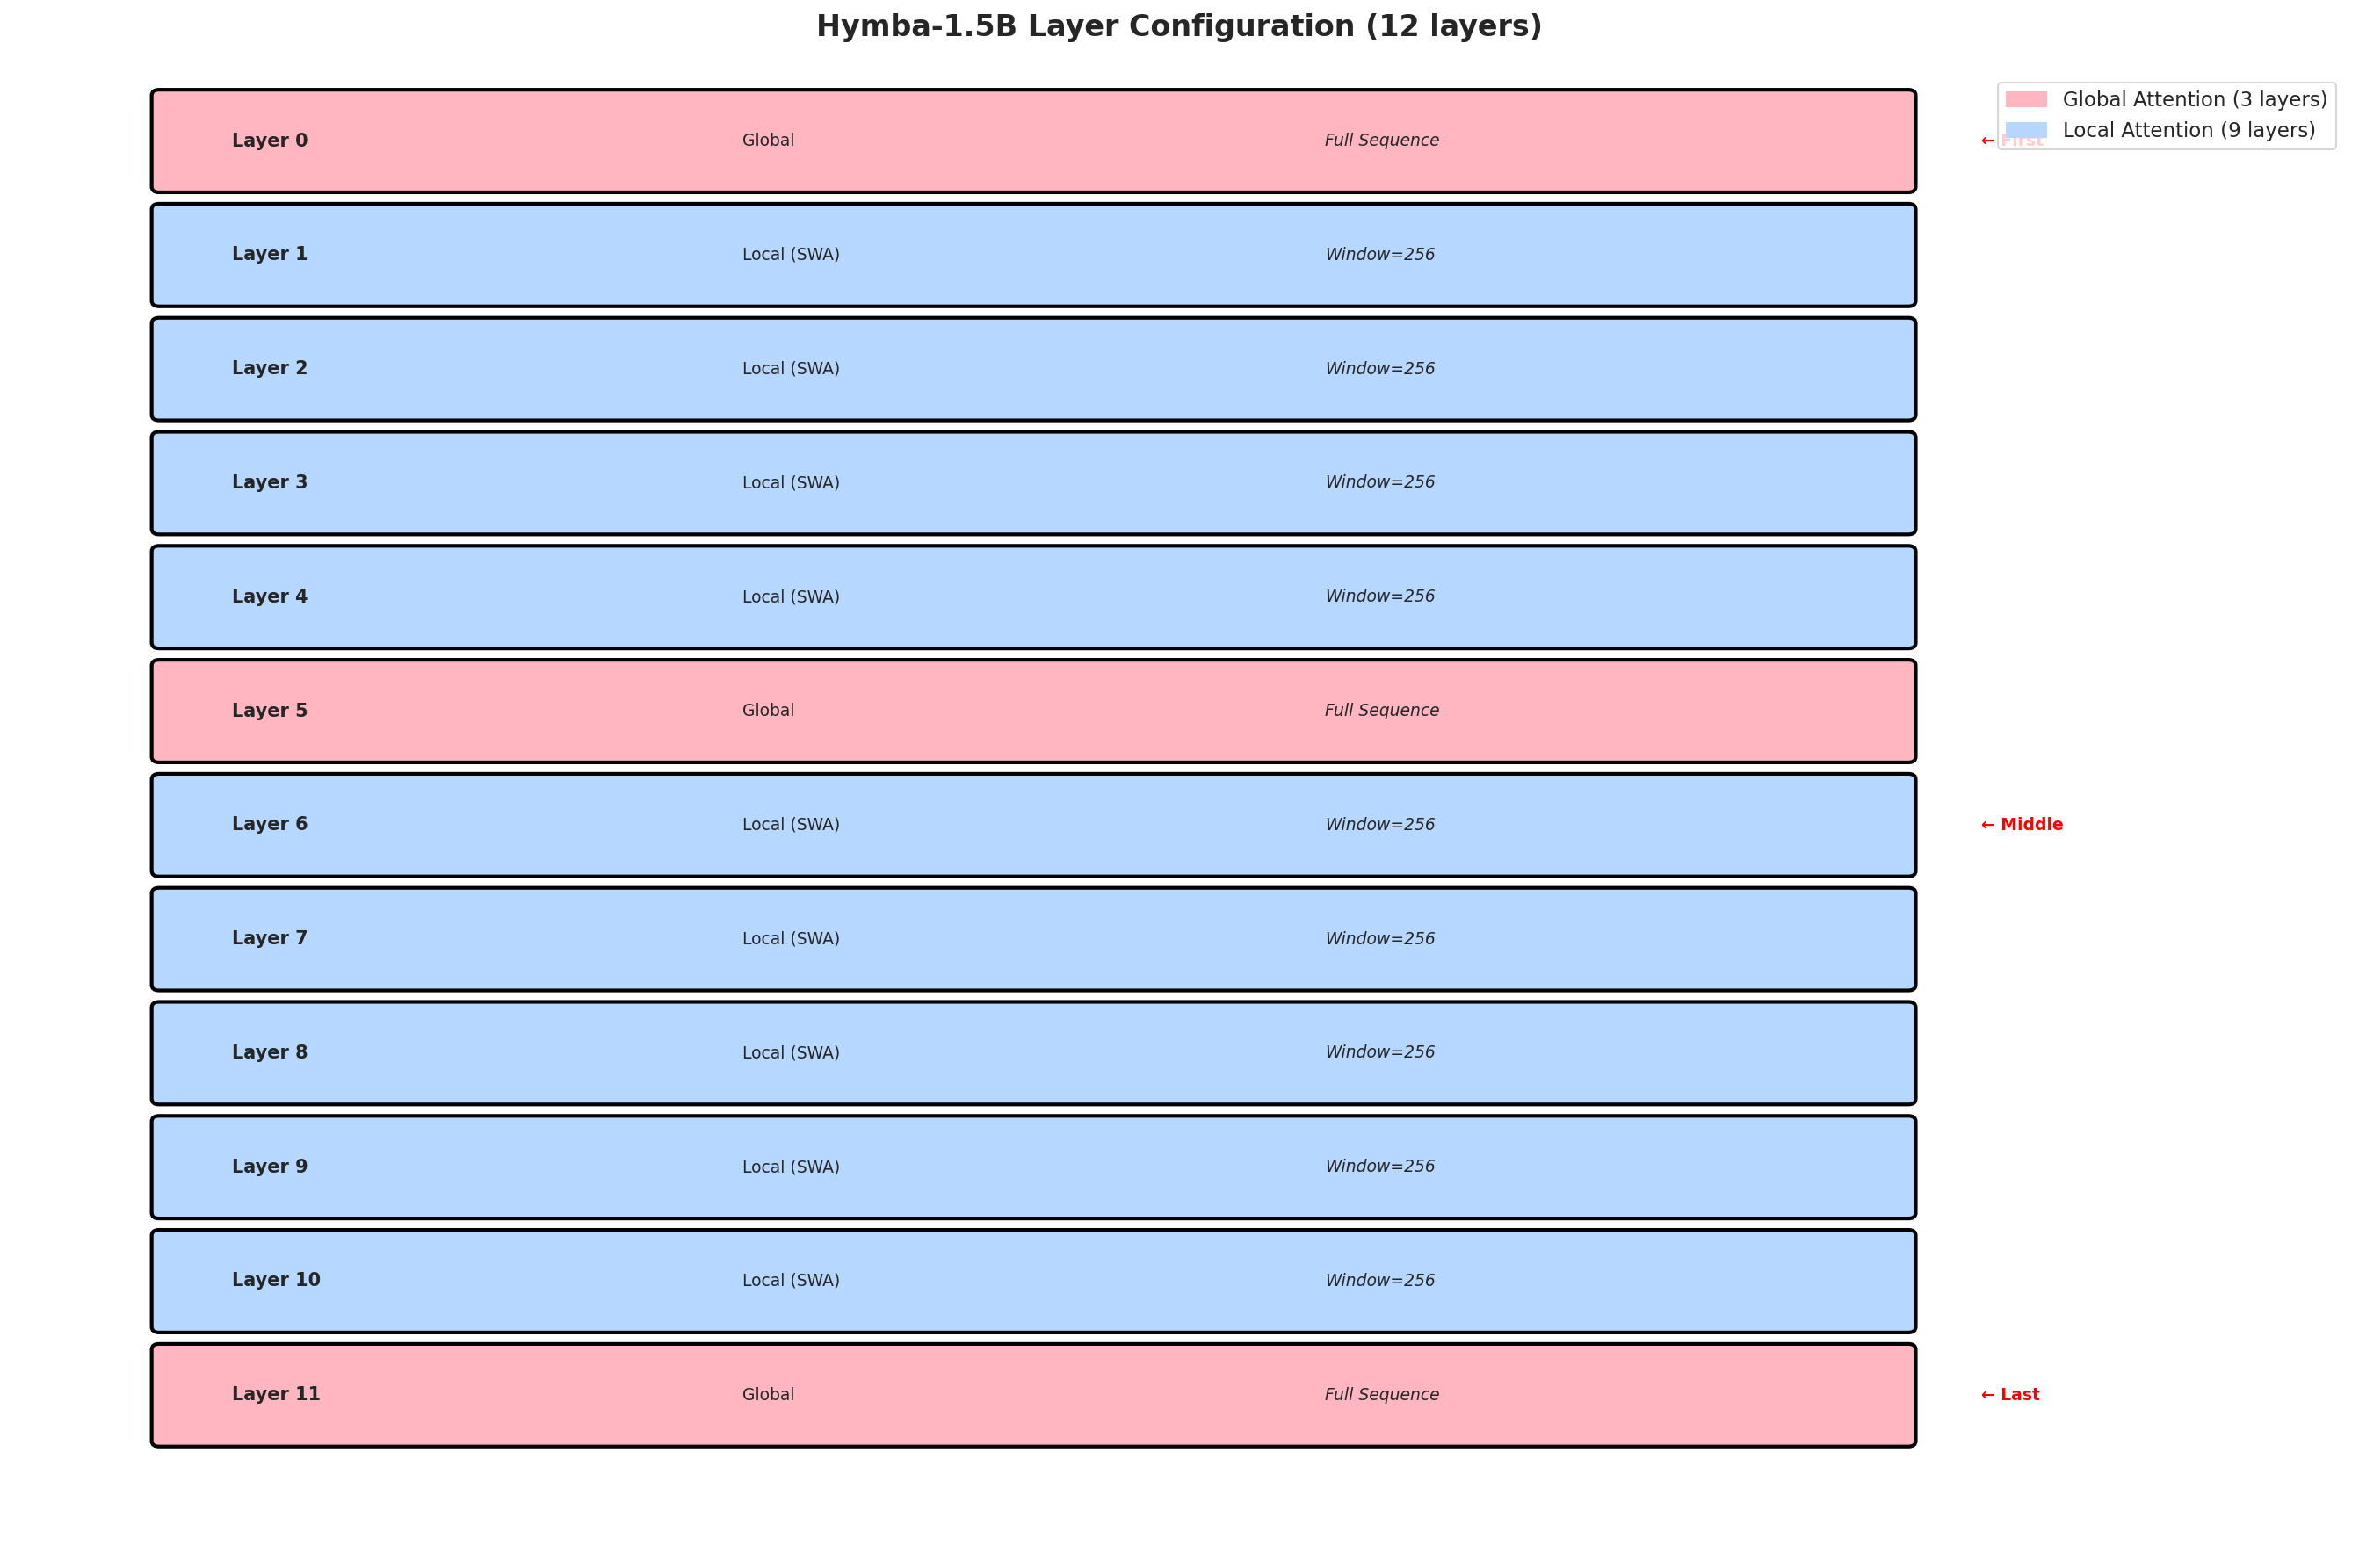

저장: ./results/hymba_layer_structure.png


In [4]:
# 레이어 구조 시각화
def visualize_layer_structure(config, attn_info):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    n_layers = config.n_layers
    attn_types = config.get_attention_types()
    
    # 색상
    color_global = '#FFB6C1'  # 연한 빨강 (Global)
    color_local = '#B6D7FF'   # 연한 파랑 (Local)
    
    # 레이어 박스 그리기
    box_height = 0.8
    for i in range(n_layers):
        y = n_layers - i - 1
        
        is_global = attn_types[i] == AttentionType.GLOBAL
        color = color_global if is_global else color_local
        label = "Global" if is_global else "Local (SWA)"
        
        # 레이어 박스
        rect = FancyBboxPatch(
            (1, y), 12, box_height,
            boxstyle="round,pad=0.05",
            edgecolor='black', facecolor=color, linewidth=2
        )
        ax.add_patch(rect)
        
        # 텍스트
        ax.text(1.5, y + box_height/2, f"Layer {i}", 
                va='center', fontsize=10, fontweight='bold')
        ax.text(5, y + box_height/2, label,
                va='center', fontsize=9)
        
        # Window 크기
        window_text = "Full Sequence" if is_global else f"Window={config.swa_window}"
        ax.text(9, y + box_height/2, window_text,
                va='center', fontsize=9, style='italic')
        
        # 특별 표시 (첫/중간/마지막)
        if i == 0:
            ax.text(13.5, y + box_height/2, "← First",
                    va='center', fontsize=9, color='red', fontweight='bold')
        elif i == n_layers // 2:
            ax.text(13.5, y + box_height/2, "← Middle",
                    va='center', fontsize=9, color='red', fontweight='bold')
        elif i == n_layers - 1:
            ax.text(13.5, y + box_height/2, "← Last",
                    va='center', fontsize=9, color='red', fontweight='bold')
    
    ax.set_xlim(0, 16)
    ax.set_ylim(-1, n_layers)
    ax.axis('off')
    
    # 범례
    global_patch = mpatches.Patch(color=color_global, label=f'Global Attention ({attn_info["num_global"]} layers)')
    local_patch = mpatches.Patch(color=color_local, label=f'Local Attention ({attn_info["num_local"]} layers)')
    ax.legend(handles=[global_patch, local_patch], loc='upper right', fontsize=11)
    
    plt.title(f'Hymba-1.5B Layer Configuration ({config.n_layers} layers)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

fig = visualize_layer_structure(config, attn_info)
plt.savefig(f'{RESULTS_DIR}/hymba_layer_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"저장: {RESULTS_DIR}/hymba_layer_structure.png")

## 3. KV-Cache 공유 패턴

In [5]:
kv_info = model.get_kv_sharing_info()

print("=== KV-Cache 공유 정보 ===")
print(f"전체 레이어: {kv_info['total_layers']}")
print(f"독립 KV 캐시: {kv_info['independent_caches']}")
print(f"메모리 절감: {kv_info['reduction']:.2f}x")

print("\n=== KV 공유 그룹 ===")
for owner, layers in sorted(kv_info['groups'].items()):
    if len(layers) > 1:
        print(f"Owner Layer {owner} → Shared by {layers}")
    else:
        print(f"Layer {owner}: 독립 (공유 안 함)")

=== KV-Cache 공유 정보 ===
전체 레이어: 12
독립 KV 캐시: 8
메모리 절감: 1.50x

=== KV 공유 그룹 ===
Layer 0: 독립 (공유 안 함)
Owner Layer 1 → Shared by [1, 2]
Owner Layer 3 → Shared by [3, 4]
Layer 5: 독립 (공유 안 함)
Owner Layer 6 → Shared by [6, 7]
Owner Layer 8 → Shared by [8, 9]
Layer 10: 독립 (공유 안 함)
Layer 11: 독립 (공유 안 함)


## 4. Attention Map 시각화

### Global vs Local 어텐션 패턴 비교

In [6]:
# 테스트 입력 (시각화를 위해 적절한 비율 유지)
# Meta: 32, Content: 96 -> 총 128 토큰 (1:3 비율)
batch_size = 1
seq_len = 96  # Content tokens만
test_input = torch.randint(0, config.vocab_size, (batch_size, seq_len)).to(device)

# 어텐션 가중치 추출
model = model.to(device).eval()
with torch.no_grad():
    output = model(test_input, return_attn=True)

attn_weights = output['attn_weights']
print(f"추출된 어텐션 맵: {len(attn_weights)}개 레이어")
print(f"어텐션 맵 크기: {attn_weights[0].shape if attn_weights[0] is not None else 'N/A'}")
print(f"  - Meta tokens: {config.num_meta_tokens}")
print(f"  - Content tokens: {seq_len}")
print(f"  - 총 시퀀스: {config.num_meta_tokens + seq_len}")

추출된 어텐션 맵: 12개 레이어
어텐션 맵 크기: torch.Size([1, 8, 128, 128])
  - Meta tokens: 32
  - Content tokens: 96
  - 총 시퀀스: 128


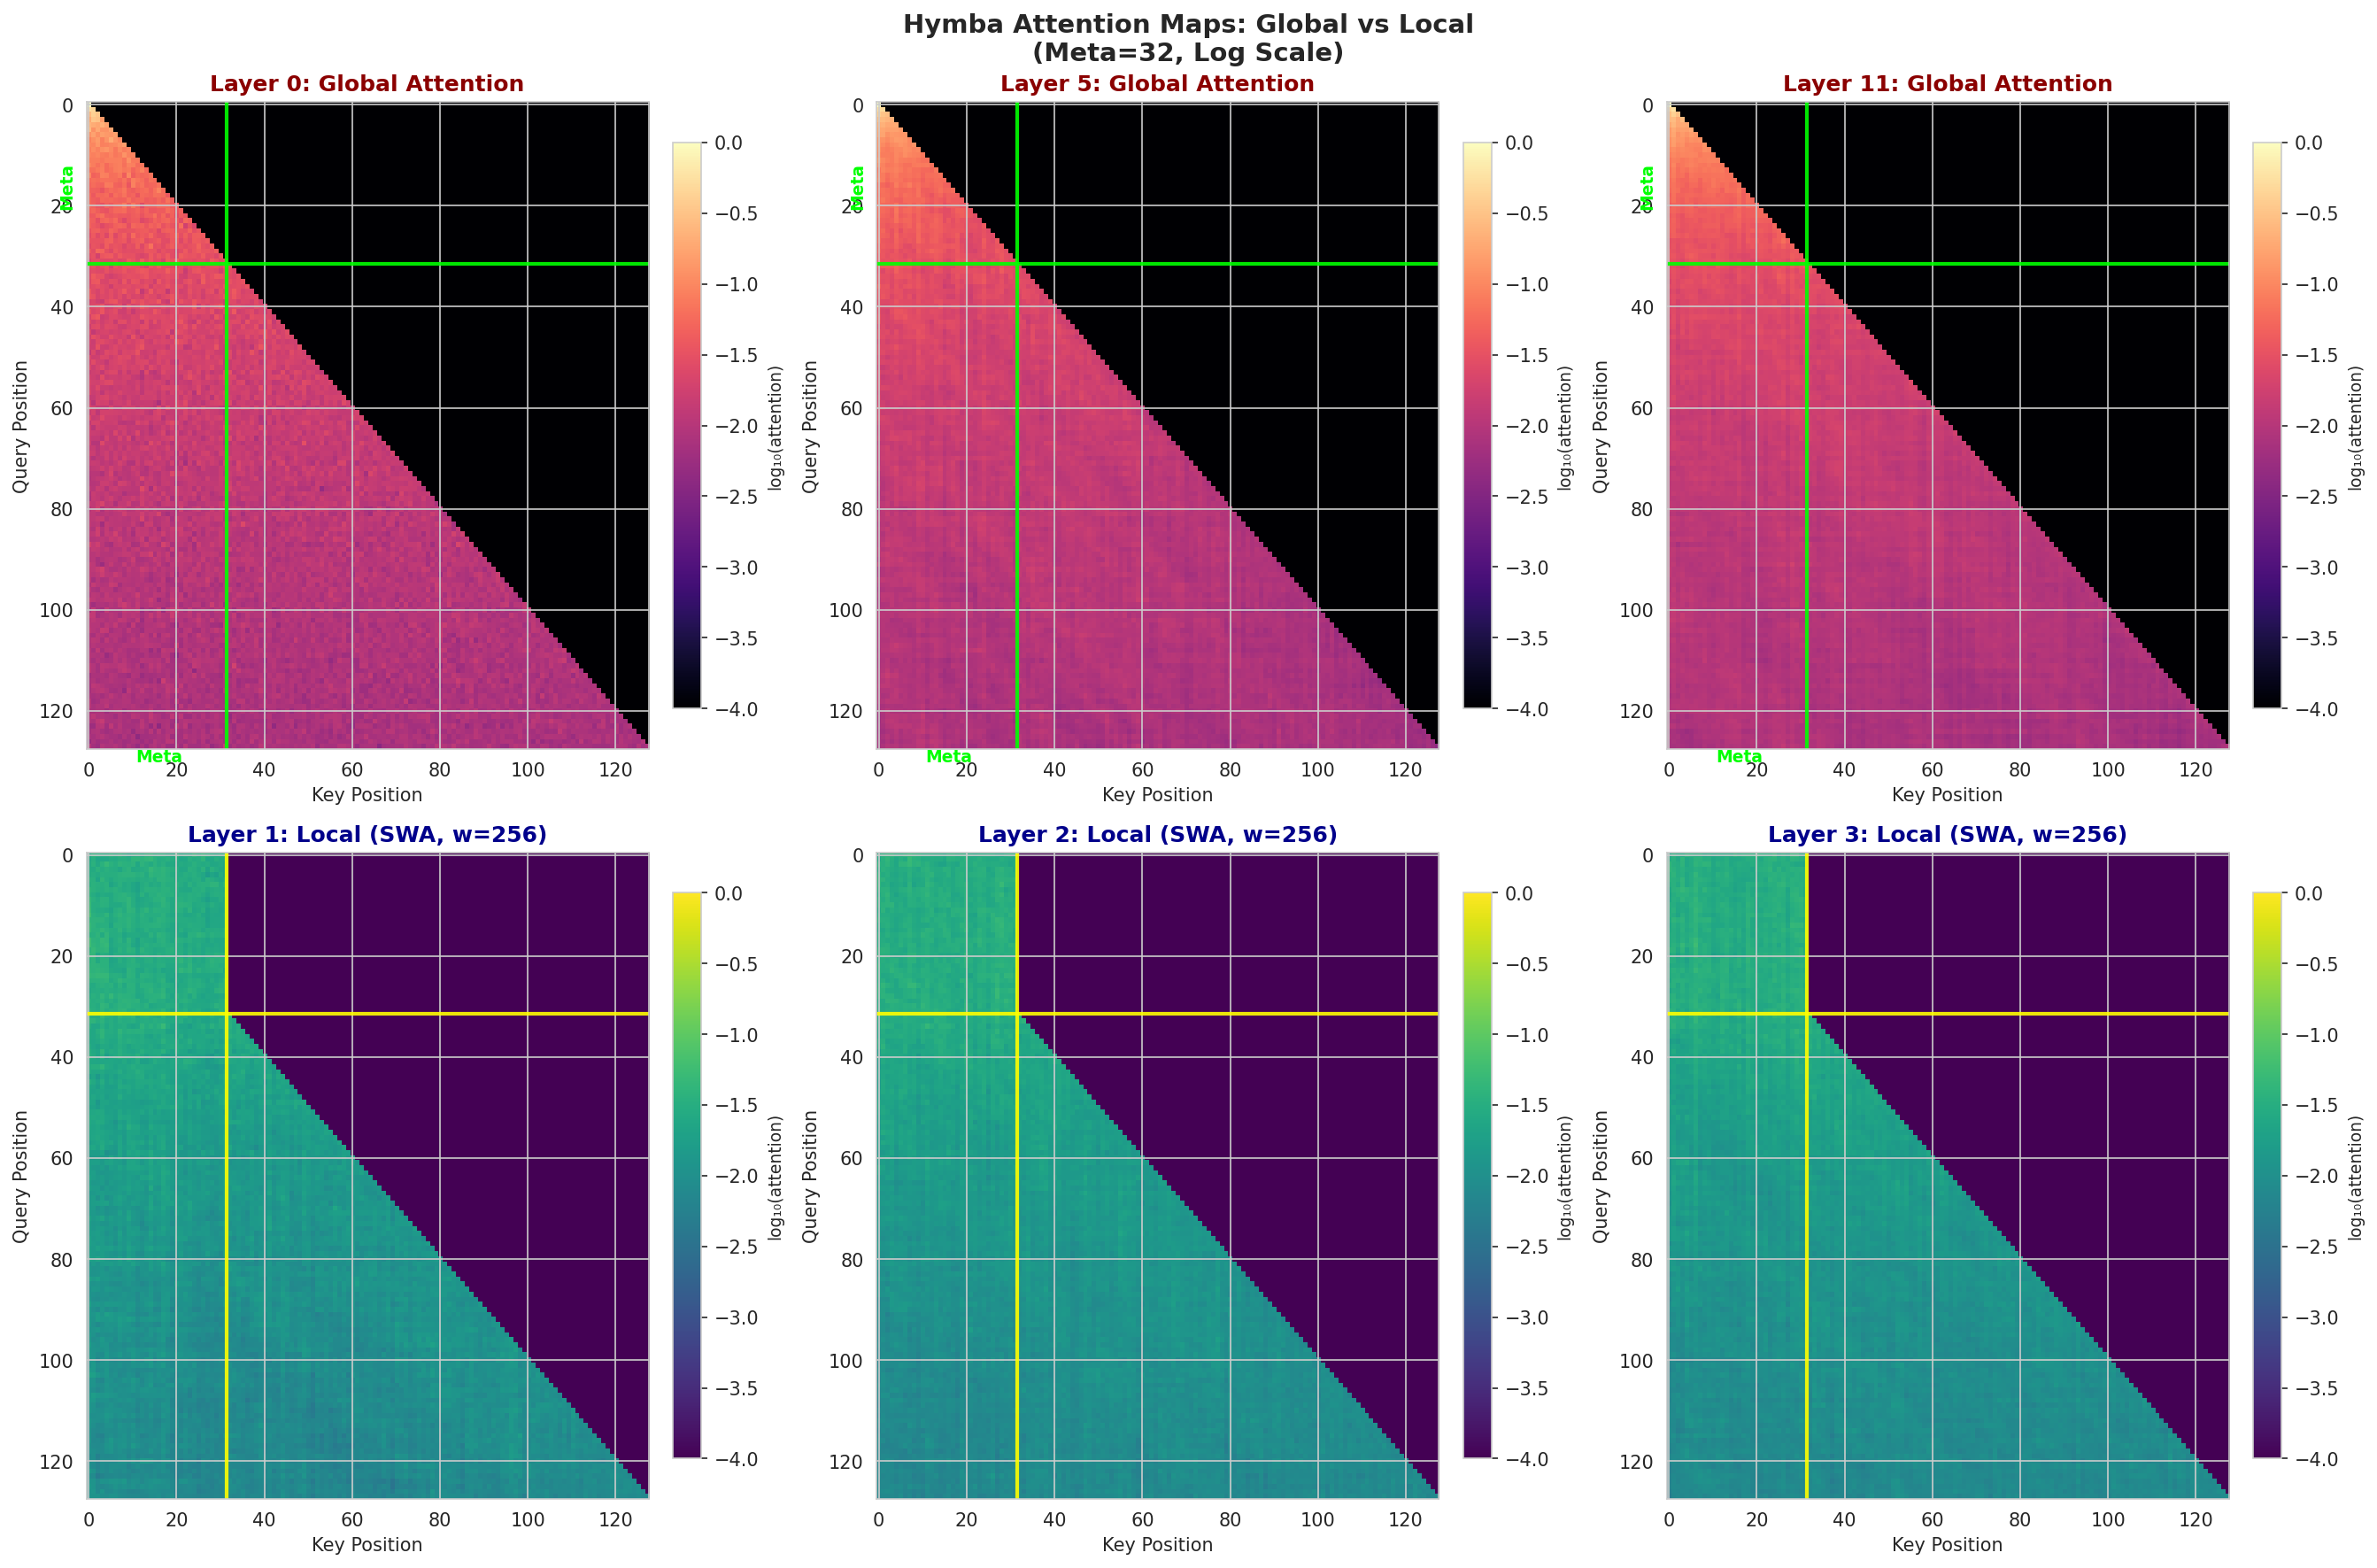

저장: ./results/attention_maps_global_vs_local.png


In [7]:
# Global vs Local 어텐션 맵 비교 (개선된 시각화)
def visualize_attention_maps(attn_weights, config):
    """
    Global과 Local 어텐션 맵을 분리하여 시각화
    
    개선사항:
    - Log scale 적용으로 작은 값도 잘 보이게
    - 더 선명한 색상 맵 사용
    - 메타 토큰 영역 명확히 표시
    """
    import matplotlib.colors as mcolors
    
    num_meta = config.num_meta_tokens
    attn_types = config.get_attention_types()
    
    # Global/Local 레이어 분리
    global_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
    local_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL][:3]
    
    n_global = len(global_indices)
    n_local = len(local_indices)
    n_total = n_global + n_local
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Global 레이어 플롯
    for layer_idx in global_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
            
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()  # [B, H, T, T] -> [T, T]
        T = attn.shape[0]
        
        ax = axes[plot_idx]
        
        # 어텐션 값 정규화 및 로그 스케일 적용
        attn_vis = attn.copy()
        attn_vis = np.clip(attn_vis, 1e-6, 1.0)
        attn_log = np.log10(attn_vis + 1e-8)
        
        im = ax.imshow(attn_log, cmap='magma', aspect='auto', vmin=-4, vmax=0)
        
        ax.set_title(f'Layer {layer_idx}: Global Attention', fontweight='bold', 
                     fontsize=12, color='darkred')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        
        # 메타 토큰 경계 표시
        if num_meta > 0 and num_meta < T:
            ax.axvline(x=num_meta-0.5, color='lime', linestyle='-', linewidth=2, alpha=0.9)
            ax.axhline(y=num_meta-0.5, color='lime', linestyle='-', linewidth=2, alpha=0.9)
            # 라벨 추가
            ax.text(num_meta/2, T+2, 'Meta', ha='center', fontsize=9, color='lime', fontweight='bold')
            ax.text(-3, num_meta/2, 'Meta', ha='right', va='center', fontsize=9, 
                    color='lime', fontweight='bold', rotation=90)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('log₁₀(attention)', fontsize=9)
        
        plot_idx += 1
    
    # Local 레이어 플롯
    for layer_idx in local_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
            
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        T = attn.shape[0]
        
        ax = axes[plot_idx]
        
        attn_vis = attn.copy()
        attn_vis = np.clip(attn_vis, 1e-6, 1.0)
        attn_log = np.log10(attn_vis + 1e-8)
        
        im = ax.imshow(attn_log, cmap='viridis', aspect='auto', vmin=-4, vmax=0)
        
        ax.set_title(f'Layer {layer_idx}: Local (SWA, w={config.swa_window})', 
                     fontweight='bold', fontsize=12, color='darkblue')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        
        # 메타 토큰 경계
        if num_meta > 0 and num_meta < T:
            ax.axvline(x=num_meta-0.5, color='yellow', linestyle='-', linewidth=2, alpha=0.9)
            ax.axhline(y=num_meta-0.5, color='yellow', linestyle='-', linewidth=2, alpha=0.9)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('log₁₀(attention)', fontsize=9)
        
        plot_idx += 1
    
    # 사용하지 않는 서브플롯 제거
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle(f'Hymba Attention Maps: Global vs Local\n(Meta={num_meta}, Log Scale)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = visualize_attention_maps(attn_weights, config)
plt.savefig(f'{RESULTS_DIR}/attention_maps_global_vs_local.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"저장: {RESULTS_DIR}/attention_maps_global_vs_local.png")

## 5. Sliding Window 패턴 검증

In [8]:
# Local 레이어의 Sliding Window 패턴 확인
def analyze_sliding_window(attn_weights, config):
    """
    Sliding Window가 올바르게 적용되었는지 확인
    """
    attn_types = config.get_attention_types()
    local_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.LOCAL]
    num_meta = config.num_meta_tokens
    
    print("=== Sliding Window 패턴 분석 ===")
    print(f"Meta tokens: {num_meta}, Window: {config.swa_window}")
    
    for layer_idx in local_indices[:3]:  # 처음 3개만
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
        
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        T = attn.shape[0]
        
        print(f"\nLayer {layer_idx} (총 시퀀스: {T}):")
        
        # 샘플 쿼리 위치 (메타 토큰 이후)
        sample_queries = [num_meta + 10, num_meta + 30, T - 10]
        
        for q_pos in sample_queries:
            if q_pos >= T:
                continue
            
            attn_row = attn[q_pos]
            nonzero_pos = np.where(attn_row > 1e-6)[0]
            
            if len(nonzero_pos) > 0:
                min_key = nonzero_pos[0]
                max_key = nonzero_pos[-1]
                window_size = max_key - min_key + 1
                
                meta_attn = attn_row[:num_meta].sum()
                content_attn = attn_row[num_meta:].sum()
                
                print(f"  Query {q_pos}: keys [{min_key}, {max_key}] (size={window_size})")
                print(f"    Meta attention: {meta_attn:.4f}, Content attention: {content_attn:.4f}")

analyze_sliding_window(attn_weights, config)

=== Sliding Window 패턴 분석 ===
Meta tokens: 32, Window: 256

Layer 1 (총 시퀀스: 128):
  Query 42: keys [0, 42] (size=43)
    Meta attention: 0.7632, Content attention: 0.2368
  Query 62: keys [0, 62] (size=63)
    Meta attention: 0.5448, Content attention: 0.4552
  Query 118: keys [0, 118] (size=119)
    Meta attention: 0.2826, Content attention: 0.7174

Layer 2 (총 시퀀스: 128):
  Query 42: keys [0, 42] (size=43)
    Meta attention: 0.7504, Content attention: 0.2496
  Query 62: keys [0, 62] (size=63)
    Meta attention: 0.5286, Content attention: 0.4714
  Query 118: keys [0, 118] (size=119)
    Meta attention: 0.2310, Content attention: 0.7690

Layer 3 (총 시퀀스: 128):
  Query 42: keys [0, 42] (size=43)
    Meta attention: 0.7306, Content attention: 0.2694
  Query 62: keys [0, 62] (size=63)
    Meta attention: 0.4723, Content attention: 0.5277
  Query 118: keys [0, 118] (size=119)
    Meta attention: 0.2797, Content attention: 0.7203


## 6. 메타 토큰 효과 분석

In [9]:
def analyze_meta_tokens(attn_weights, config):
    """
    메타 토큰에 대한 어텐션 패턴 분석
    """
    M = config.num_meta_tokens
    attn_types = config.get_attention_types()
    global_indices = [i for i, t in enumerate(attn_types) if t == AttentionType.GLOBAL]
    
    print("=== 메타 토큰 어텐션 분석 ===")
    print(f"메타 토큰 수: {M}\n")
    
    for layer_idx in global_indices:
        if layer_idx >= len(attn_weights) or attn_weights[layer_idx] is None:
            continue
        
        attn = attn_weights[layer_idx][0, 0].cpu().numpy()
        T = attn.shape[0]
        
        if M >= T:
            print(f"Warning: Meta tokens ({M}) >= Total sequence ({T})")
            continue
        
        # 일반 토큰(메타 이후)이 메타 토큰에 주는 어텐션
        content_to_meta = attn[M:, :M].mean()
        # 일반 토큰끼리의 어텐션
        content_to_content = attn[M:, M:].mean()
        # 메타 토큰끼리의 어텐션
        meta_to_meta = attn[:M, :M].mean()
        
        layer_type = "Global" if attn_types[layer_idx] == AttentionType.GLOBAL else "Local"
        print(f"Layer {layer_idx} ({layer_type}):")
        print(f"  Content → Meta: {content_to_meta:.6f}")
        print(f"  Content → Content: {content_to_content:.6f}")
        print(f"  Meta → Meta: {meta_to_meta:.6f}")
        ratio = content_to_meta / (content_to_content + 1e-9)
        print(f"  비율 (Content→Meta / Content→Content): {ratio:.2f}x\n")

analyze_meta_tokens(attn_weights, config)

=== 메타 토큰 어텐션 분석 ===
메타 토큰 수: 32

Layer 0 (Global):
  Content → Meta: 0.014387
  Content → Content: 0.005621
  Meta → Meta: 0.031250
  비율 (Content→Meta / Content→Content): 2.56x

Layer 5 (Global):
  Content → Meta: 0.014723
  Content → Content: 0.005509
  Meta → Meta: 0.031250
  비율 (Content→Meta / Content→Content): 2.67x

Layer 11 (Global):
  Content → Meta: 0.014775
  Content → Content: 0.005492
  Meta → Meta: 0.031250
  비율 (Content→Meta / Content→Content): 2.69x



## 7. 종합 요약

In [10]:
print("\n" + "="*80)
print("Hymba 아키텍처 검증 요약")
print("="*80)

attn_info = model.get_attention_pattern_info()
kv_info = model.get_kv_sharing_info()

print("\n1. 모델 구성:")
print(f"   - 전체 레이어: {config.n_layers}")
print(f"   - 파라미터: {params['total']:,}")
print(f"   - 모델 크기: {params['total'] * 4 / 1024**3:.2f} GB (FP32)")

print("\n2. Attention 패턴:")
print(f"   - Global Attention: {attn_info['global_layers']} (총 {attn_info['num_global']}개)")
print(f"   - Local Attention: 나머지 {attn_info['num_local']}개 레이어")
print(f"   - Sliding Window: {config.swa_window} 토큰")

print("\n3. 메타 토큰:")
print(f"   - 개수: {config.num_meta_tokens}개")
print(f"   - 역할: 전역 컨텍스트 저장, Attention Sink 방지")

print("\n4. KV-Cache 공유:")
print(f"   - 독립 캐시: {kv_info['independent_caches']}개")
print(f"   - 메모리 절감: {kv_info['reduction']:.2f}x")

print("\n5. 시각화 설정:")
print(f"   - Meta tokens: {config.num_meta_tokens}")
print(f"   - Content tokens: {seq_len}")
print(f"   - 총 시퀀스: {config.num_meta_tokens + seq_len}")

print("\n" + "="*80)


Hymba 아키텍처 검증 요약

1. 모델 구성:
   - 전체 레이어: 12
   - 파라미터: 71,672,320
   - 모델 크기: 0.27 GB (FP32)

2. Attention 패턴:
   - Global Attention: [0, 5, 11] (총 3개)
   - Local Attention: 나머지 9개 레이어
   - Sliding Window: 256 토큰

3. 메타 토큰:
   - 개수: 32개
   - 역할: 전역 컨텍스트 저장, Attention Sink 방지

4. KV-Cache 공유:
   - 독립 캐시: 8개
   - 메모리 절감: 1.50x

5. 시각화 설정:
   - Meta tokens: 32
   - Content tokens: 96
   - 총 시퀀스: 128

